In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lightweight_clustered_energy_forecasts.utils.paths import data_dir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import math

c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Funciones auxiliares

In [16]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isna().any():
            nan_polluted_series_counter += 1
    print(nan_polluted_series_counter)

## Procesing data

In [17]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [18]:
building_11a=building_11a.resample("h").sum()

In [19]:
#realizamos una lista de arrays cada array correspondiendo a 1 dia de datos con frecuencia de muestreo por 15 minutos
# Agrupar por día
df=building_11a.copy()
# Agrupar por día y guardar los DataFrames en una lista
list_of_dataframes = [group for _, group in df.groupby(df.index.date)]

# Imprimir el resultado
for i, daily_df in enumerate(list_of_dataframes):
    print(f"Día {i+1}:")
    print(daily_df)
    print("-" * 50)


Día 1:
                             kwh
timestamp                       
2023-01-01 00:00:00+00:00  54.90
2023-01-01 01:00:00+00:00  53.81
2023-01-01 02:00:00+00:00  52.92
2023-01-01 03:00:00+00:00  55.99
2023-01-01 04:00:00+00:00  57.55
2023-01-01 05:00:00+00:00  53.89
2023-01-01 06:00:00+00:00  52.87
2023-01-01 07:00:00+00:00  46.73
2023-01-01 08:00:00+00:00  51.08
2023-01-01 09:00:00+00:00  55.15
2023-01-01 10:00:00+00:00  51.41
2023-01-01 11:00:00+00:00  57.62
2023-01-01 12:00:00+00:00  56.59
2023-01-01 13:00:00+00:00  59.29
2023-01-01 14:00:00+00:00  61.22
2023-01-01 15:00:00+00:00  60.16
2023-01-01 16:00:00+00:00  57.73
2023-01-01 17:00:00+00:00  59.19
2023-01-01 18:00:00+00:00  61.27
2023-01-01 19:00:00+00:00  65.10
2023-01-01 20:00:00+00:00  57.67
2023-01-01 21:00:00+00:00  58.05
2023-01-01 22:00:00+00:00  59.79
2023-01-01 23:00:00+00:00  60.30
--------------------------------------------------
Día 2:
                             kwh
timestamp                       
2023-01-02 

In [20]:
nan_counter(list_of_dataframes)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [8]:
len(list_of_dataframes)

365

<Axes: xlabel='timestamp'>

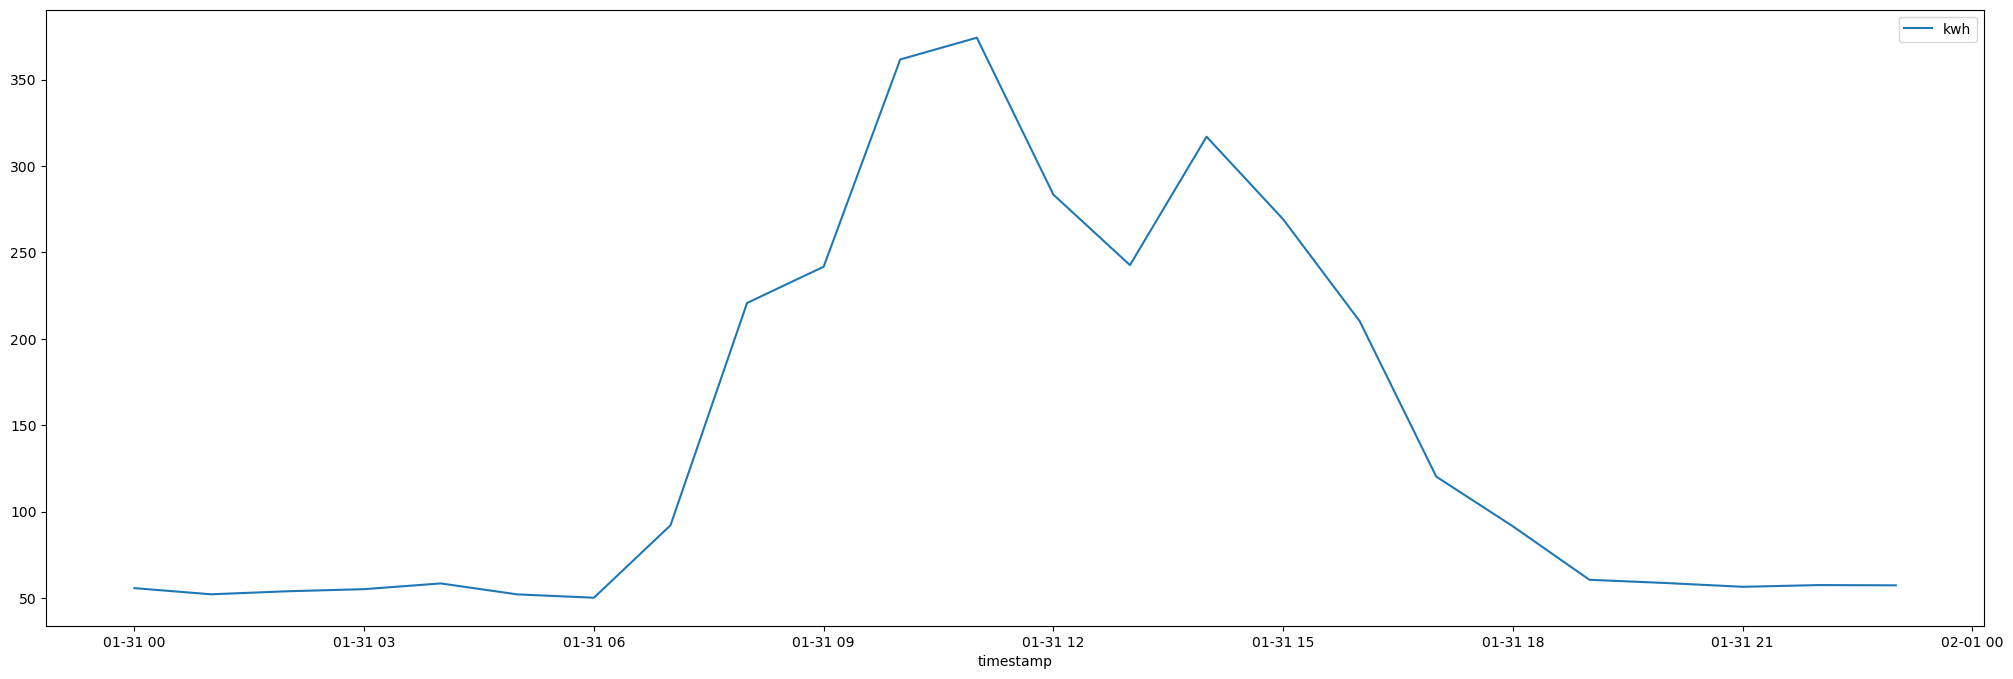

In [21]:
sns.lineplot(list_of_dataframes[30])

## clustering

Después de gestionar los valores faltantes, el otro problema es la escala de la serie. Sin la normalización de los datos, las series que se parecen entre sí se verán muy diferentes entre sí y afectarán la precisión del proceso de agrupamiento. Podemos ver el efecto de la normalización en las siguientes imágenes.

In [22]:
normalized_list_of_dataframes = []

for daily_df in list_of_dataframes:
    scaler = MinMaxScaler()
    # Normalizar cada día por separado
    normalized_daily_df = scaler.fit_transform(daily_df.values.reshape(-1, 1))  # Reshape para ajustarse a la entrada del scaler
    normalized_list_of_dataframes.append(normalized_daily_df.flatten())  # Volver a la forma 1D


El resultado del proceso de normalización parece bueno.

In [23]:
print("max: "+str(max(normalized_list_of_dataframes[0]))+"\tmin: "+str(min(normalized_list_of_dataframes[0])))
print(normalized_list_of_dataframes[0][:5])

max: 1.0	min: 0.0
[0.44474687 0.385411   0.33696244 0.50408274 0.58900381]


## kmeans

In [24]:
# Definir el rango de k para probar
K = range(2, 8)
Sum_of_squared_distances = []
Silhouette_Scores = []

# Probar con diferentes valores de k
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",  # Usamos DTW como métrica de distancia
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    # Ajustar el modelo a los datos
    km = km.fit(normalized_list_of_dataframes)
    
    # Almacenar la inercia para este valor de k
    Sum_of_squared_distances.append(km.inertia_)
    silhouette = silhouette_score(normalized_list_of_dataframes, km.labels_)
    Silhouette_Scores.append(silhouette)

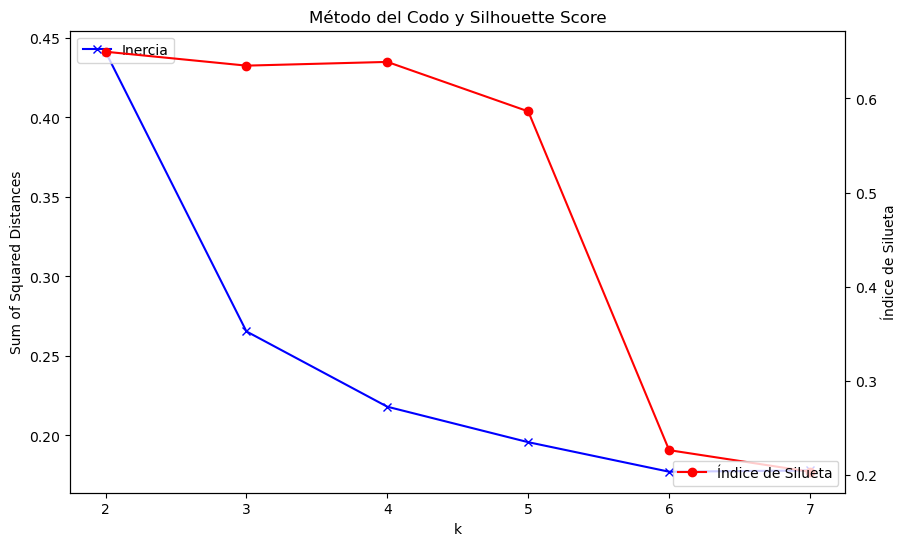

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico del codo (inercia)
ax1.plot(K, Sum_of_squared_distances, 'bx-', label="Inercia")
ax1.set_xlabel('k')
ax1.set_ylabel('Sum of Squared Distances')
ax1.set_title('Método del Codo y Silhouette Score')

# Crear un segundo eje y para el índice de silueta
ax2 = ax1.twinx()
ax2.plot(K, Silhouette_Scores, 'ro-', label="Índice de Silueta")
ax2.set_ylabel('Índice de Silueta')

# Mostrar la leyenda
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

In [26]:
Sum_of_squared_distances

[np.float64(0.44130106822624143),
 np.float64(0.2654060092499969),
 np.float64(0.21803211406482984),
 np.float64(0.19572773501533122),
 np.float64(0.17714936074504653),
 np.float64(0.17794310812958056)]

## Training  kmeans 

usando distancia Euclidiana

In [27]:
# Aplicar el clustering con el número óptimo de clusters
optimal_k = 4
km = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", verbose=False)

# Ajustar el modelo y predecir las etiquetas de los clusters
labels = km.fit_predict(normalized_list_of_dataframes)

# Mostrar las primeras etiquetas de los clusters
print("Etiquetas de los clusters para las primeras series:", labels[:5])


Etiquetas de los clusters para las primeras series: [2 2 0 0 0]


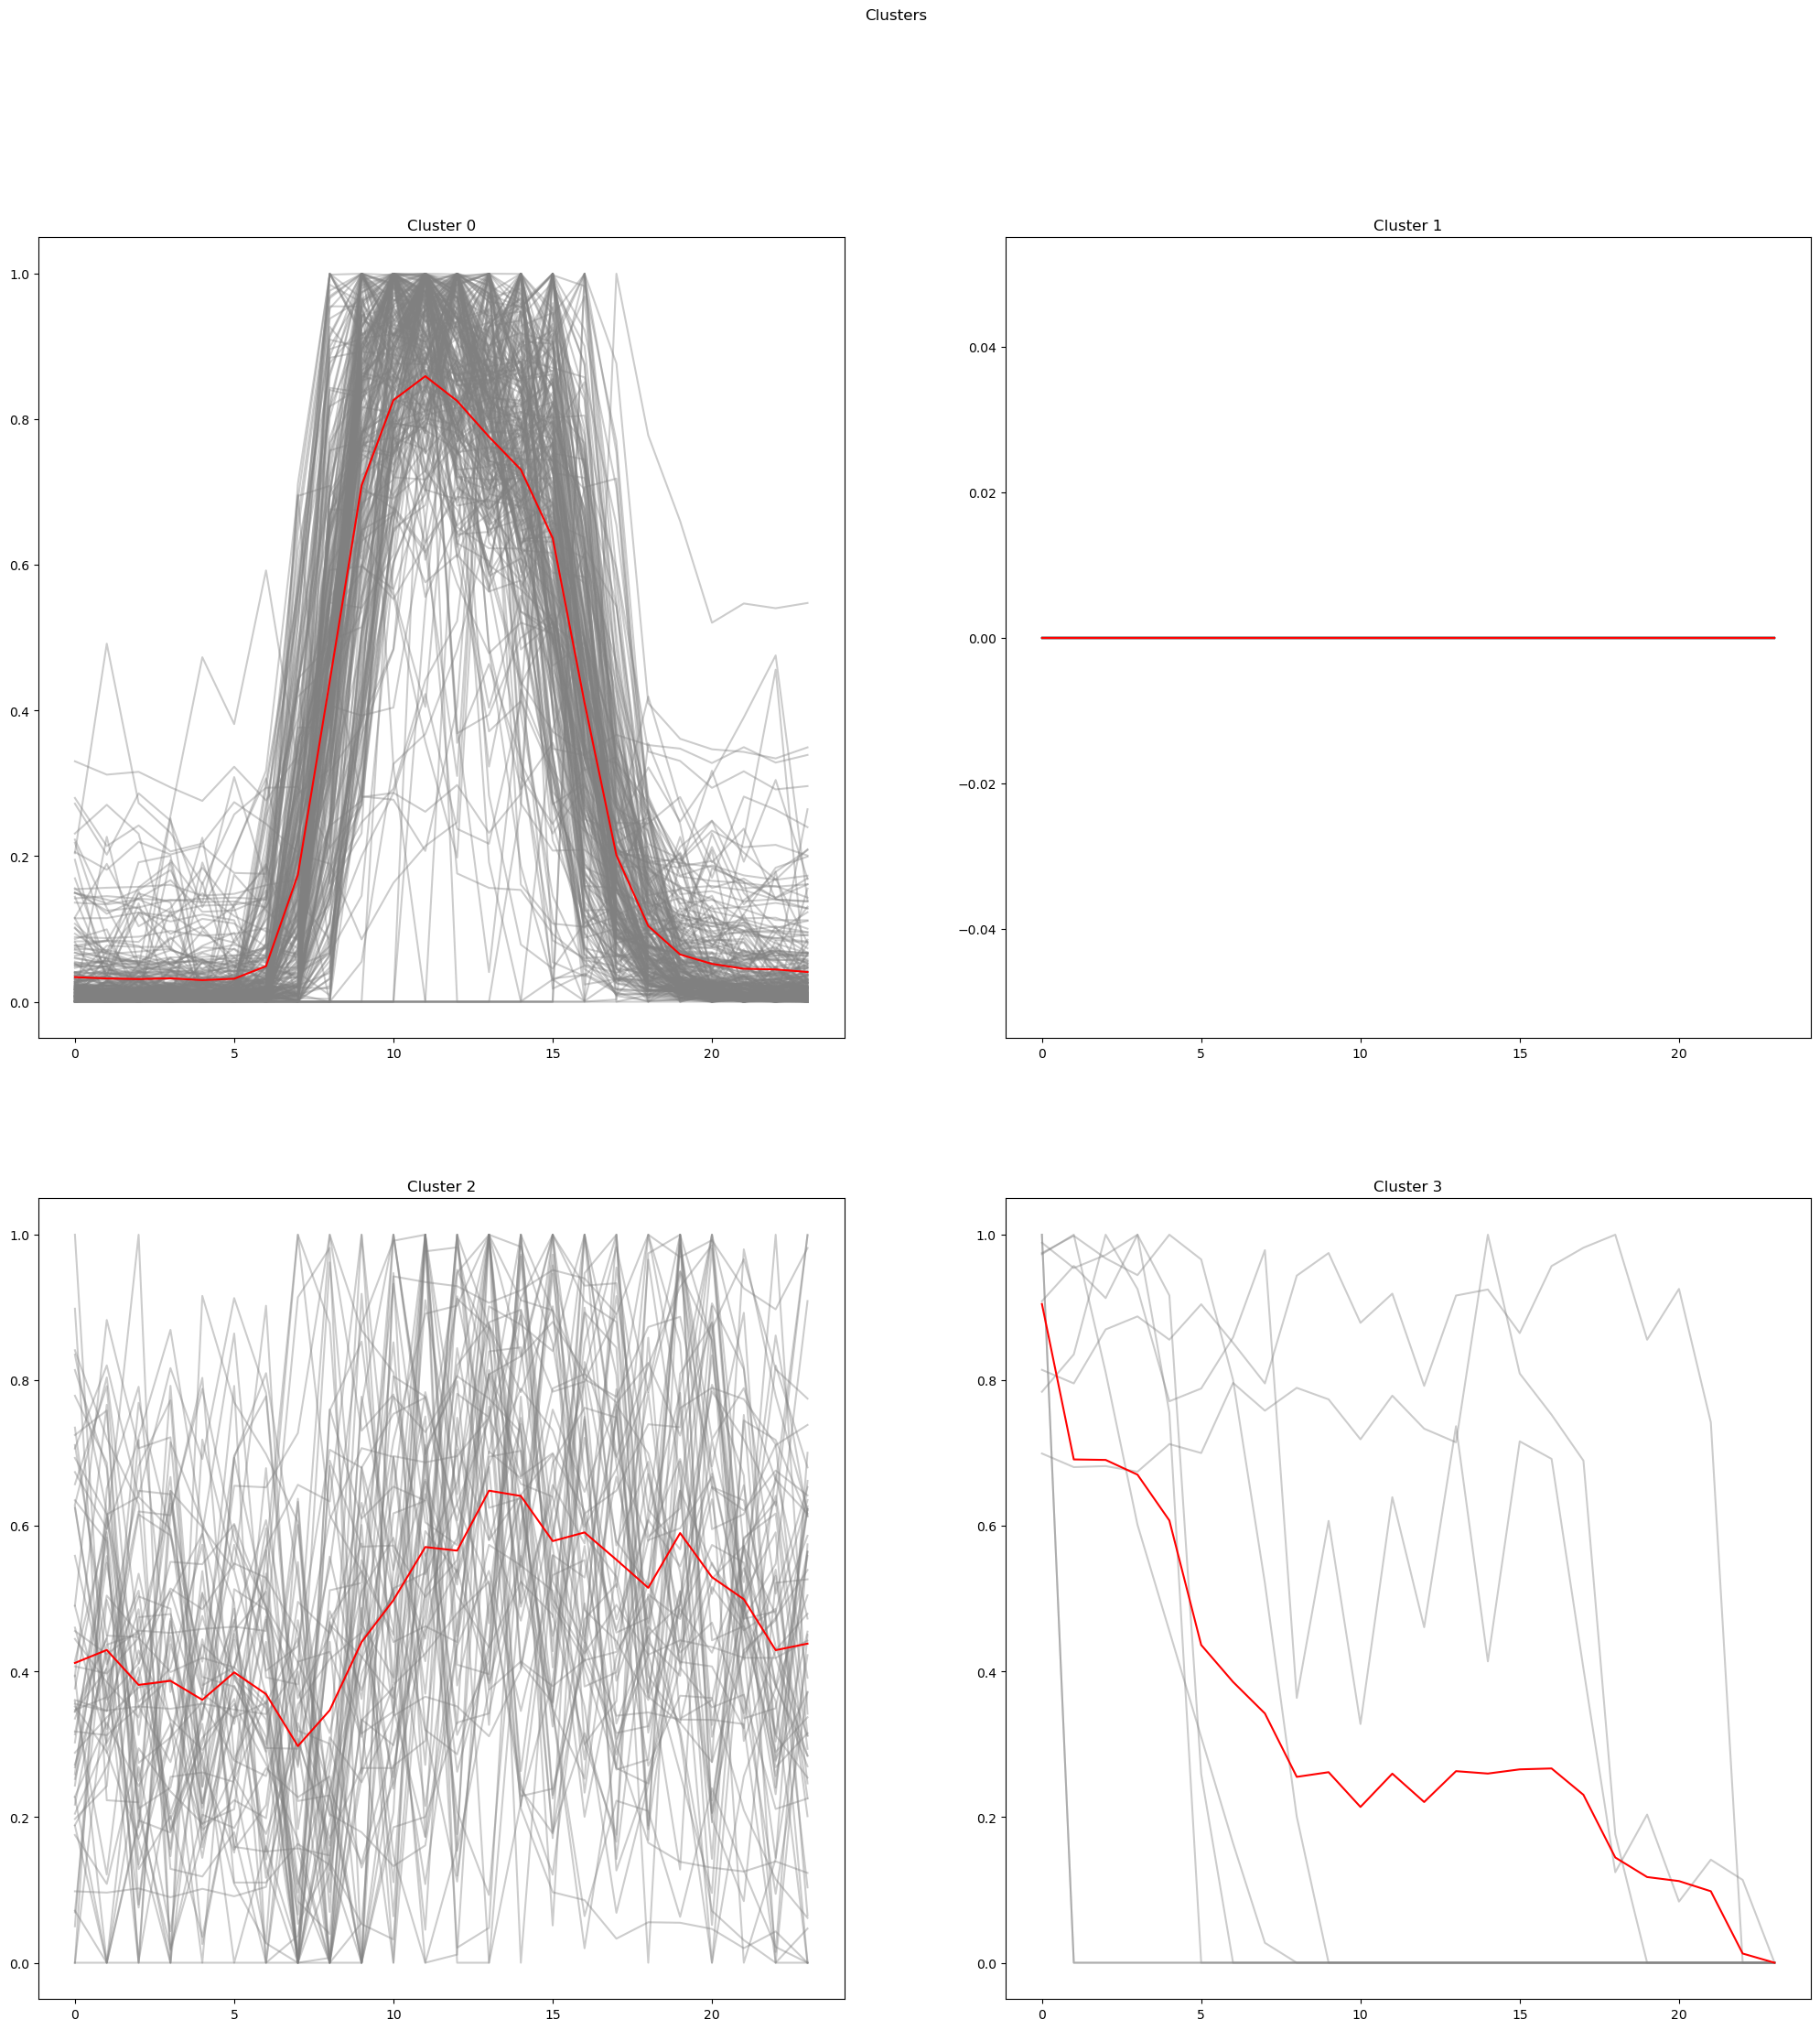

In [28]:
# Número de subgráficas
plot_count = math.ceil(math.sqrt(optimal_k))

# Crear una figura para los gráficos
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')

row_i = 0
column_j = 0

# Para cada etiqueta de cluster, trazamos las series de tiempo y su promedio
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(normalized_list_of_dataframes[i], c="gray", alpha=0.4)
            cluster.append(normalized_list_of_dataframes[i])
    
    # Si el cluster tiene series, trazamos su promedio
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    
    axs[row_i, column_j].set_title(f"Cluster {label}")
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

# Mostrar el gráfico
plt.show()

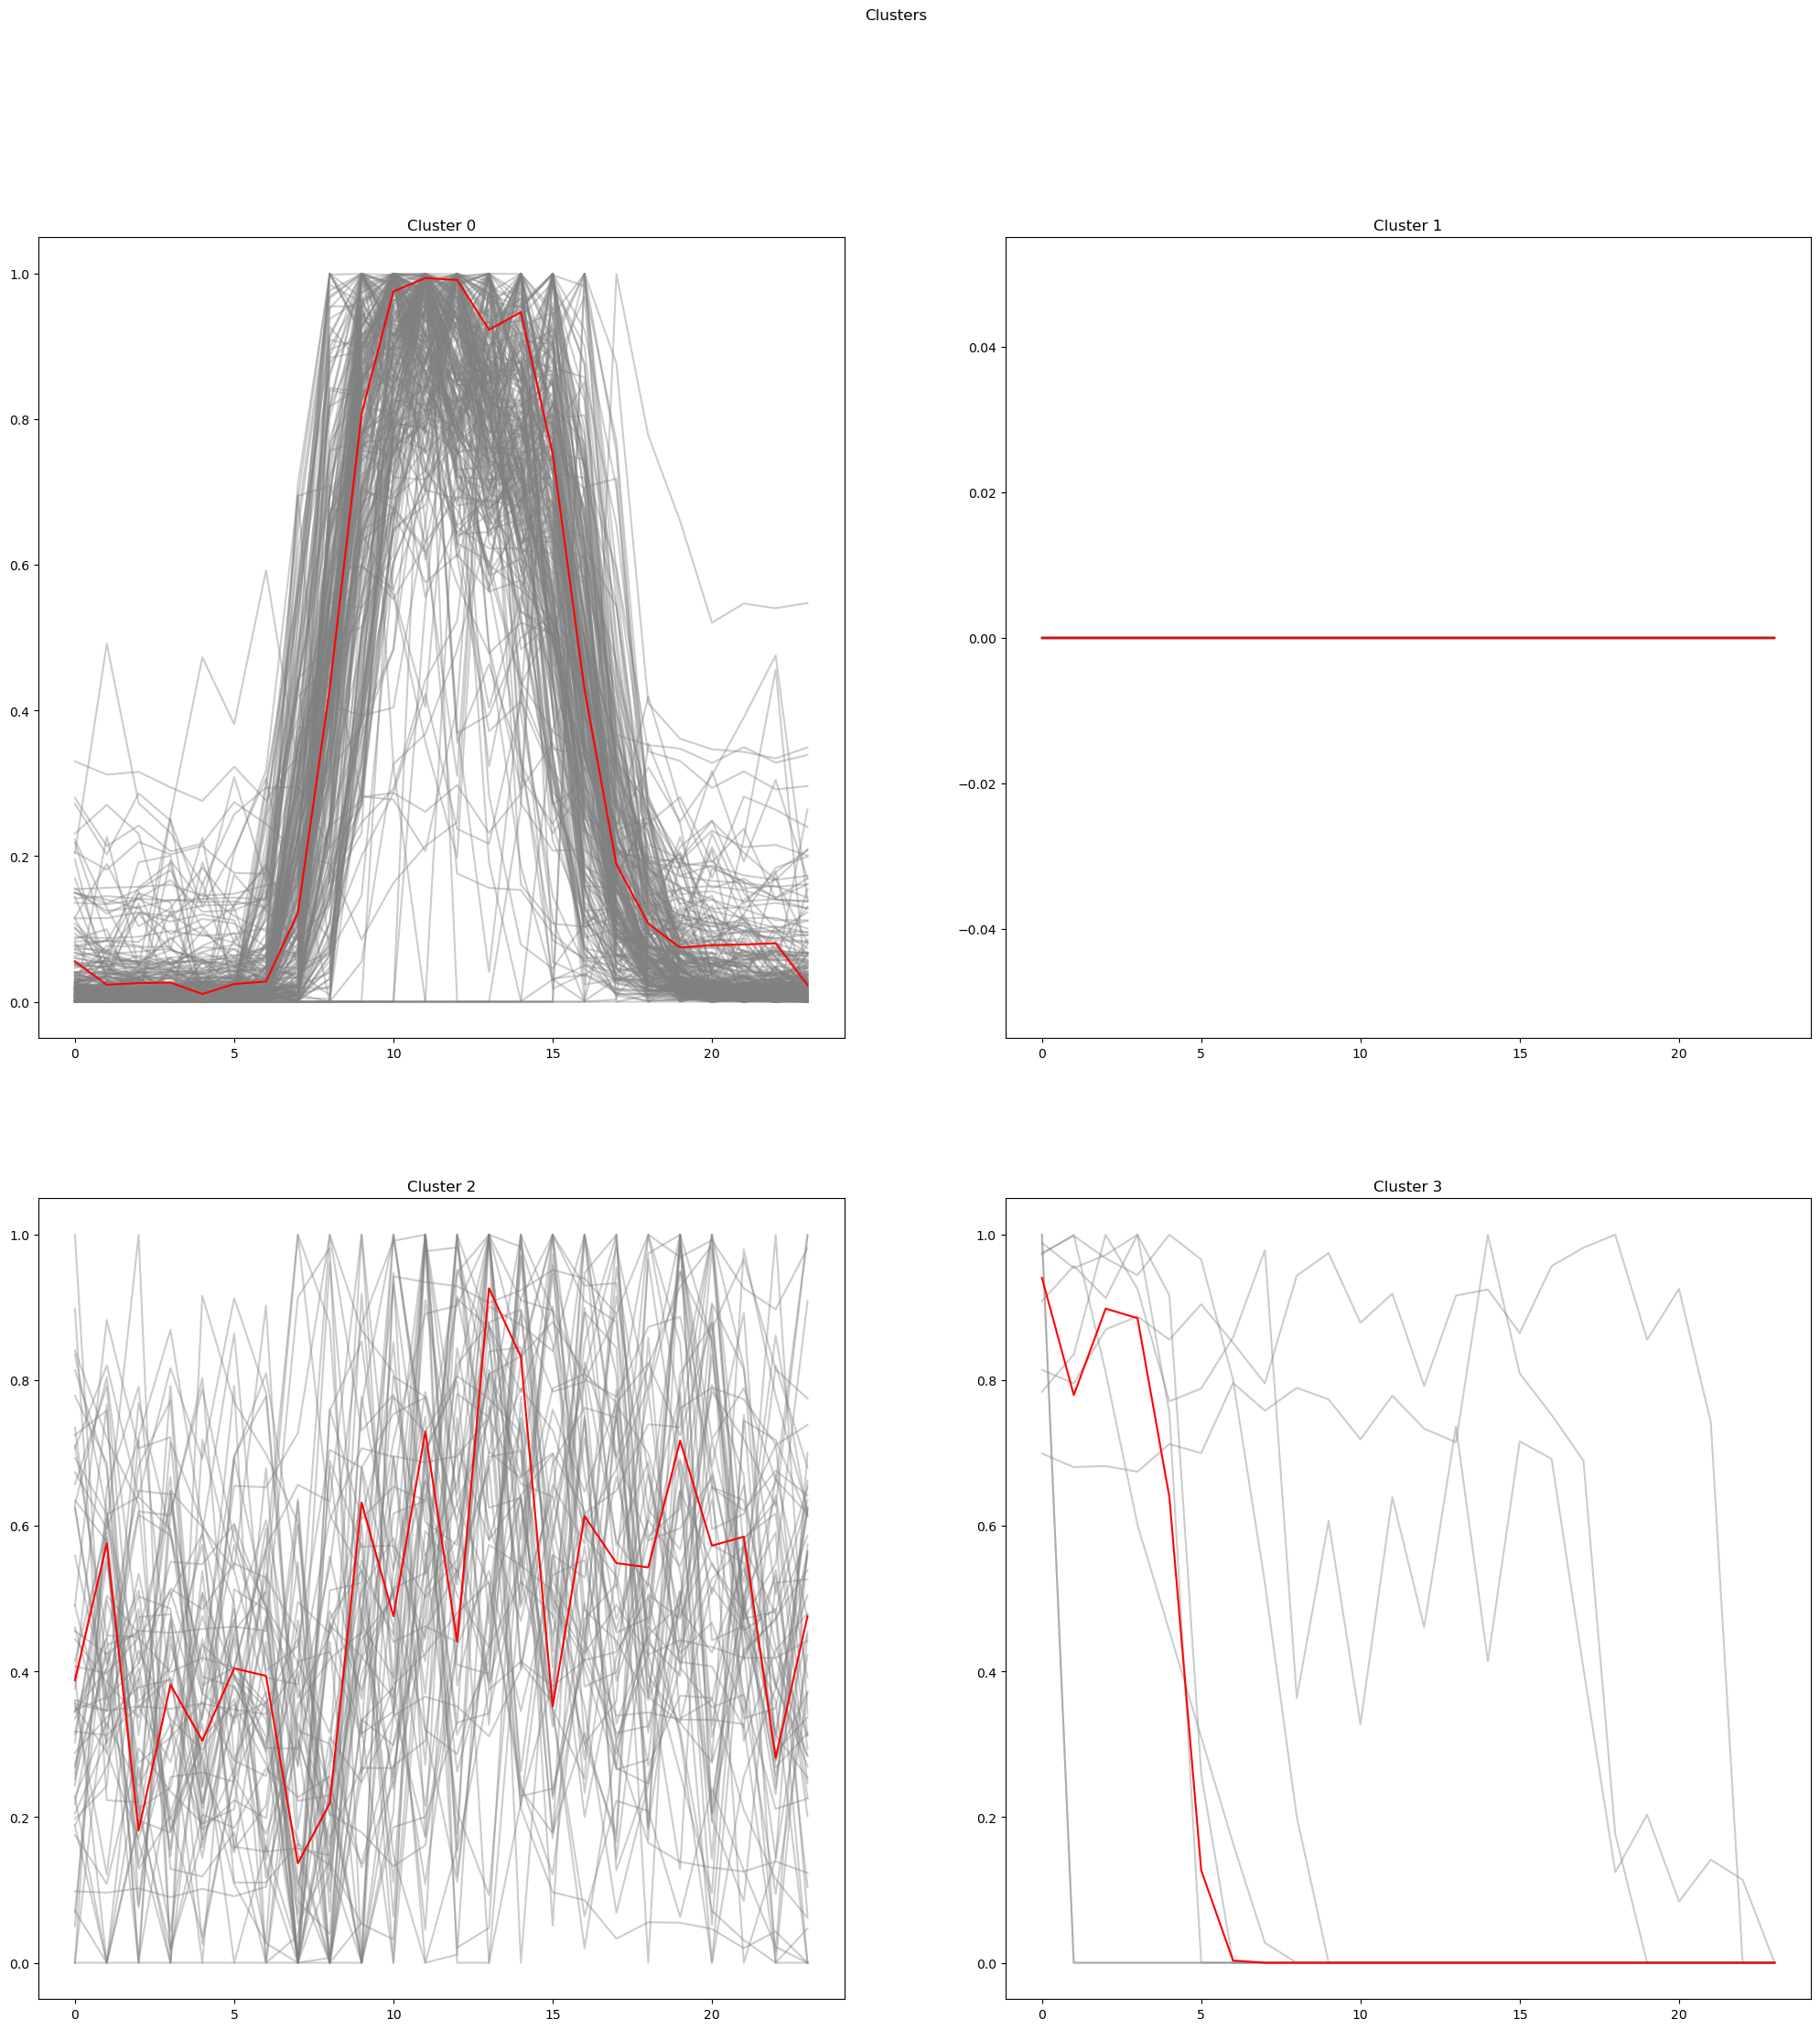

In [29]:
from tslearn.barycenters import dtw_barycenter_averaging

# Número de subgráficas
plot_count = math.ceil(math.sqrt(optimal_k))

# Crear una figura para los gráficos
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')

row_i = 0
column_j = 0

# Para cada etiqueta de cluster, trazamos las series de tiempo y su promedio
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(normalized_list_of_dataframes[i], c="gray", alpha=0.4)
            cluster.append(normalized_list_of_dataframes[i])
    
    # Si el cluster tiene series, trazamos su promedio
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)), c="red")
    
    axs[row_i, column_j].set_title(f"Cluster {label}")
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

# Mostrar el gráfico
plt.show()

Cantidad de series en cada cluster: [np.int64(247), np.int64(49), np.int64(60), np.int64(9)]


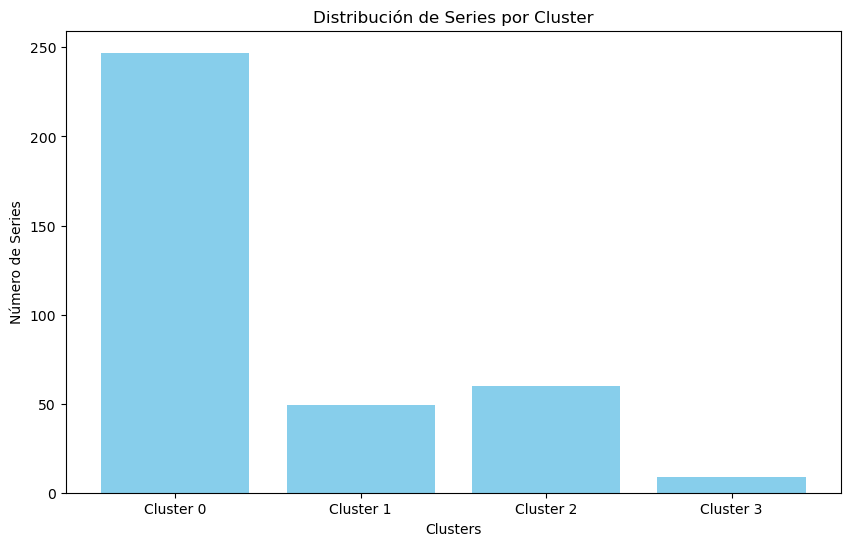

In [30]:
# Contar cuántas series pertenecen a cada cluster
cluster_counts = [np.sum(labels == i) for i in range(optimal_k)]

# Mostrar la cantidad de series en cada cluster
print("Cantidad de series en cada cluster:", cluster_counts)

# Etiquetas para los clusters
cluster_labels = [f"Cluster {i}" for i in range(optimal_k)]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(cluster_labels, cluster_counts, color='skyblue')
plt.title("Distribución de Series por Cluster")
plt.xlabel("Clusters")
plt.ylabel("Número de Series")
plt.show()


In [104]:
# Crear una lista vacía para almacenar las fechas y las etiquetas de los clusters
dates = []
cluster_labels = []

# Recorrer las series de tiempo, y asignar las fechas y las etiquetas correspondientes
for i, daily_df in enumerate(list_of_dataframes):
    current_dates = daily_df.index  # Obtener las fechas de este día
    dates.extend(current_dates)  # Añadir las fechas
    cluster_labels.extend([labels[i]] * len(current_dates))  # Añadir la etiqueta del cluster para cada fecha

# Crear un DataFrame con las fechas y las etiquetas de los clusters
df_clusters = pd.DataFrame({
    'Date': dates,
    'Cluster': cluster_labels
})

# Ver las primeras filas para verificar
df_clusters.head()



,Date,Cluster
0,2023-01-01 00:00:00+00:00,2
1,2023-01-01 01:00:00+00:00,2
2,2023-01-01 02:00:00+00:00,2
3,2023-01-01 03:00:00+00:00,2
4,2023-01-01 04:00:00+00:00,2


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_6124\276328713.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_distribution = df_clusters.groupby(['Cluster', 'Weekday']).size().unstack(fill_value=0)


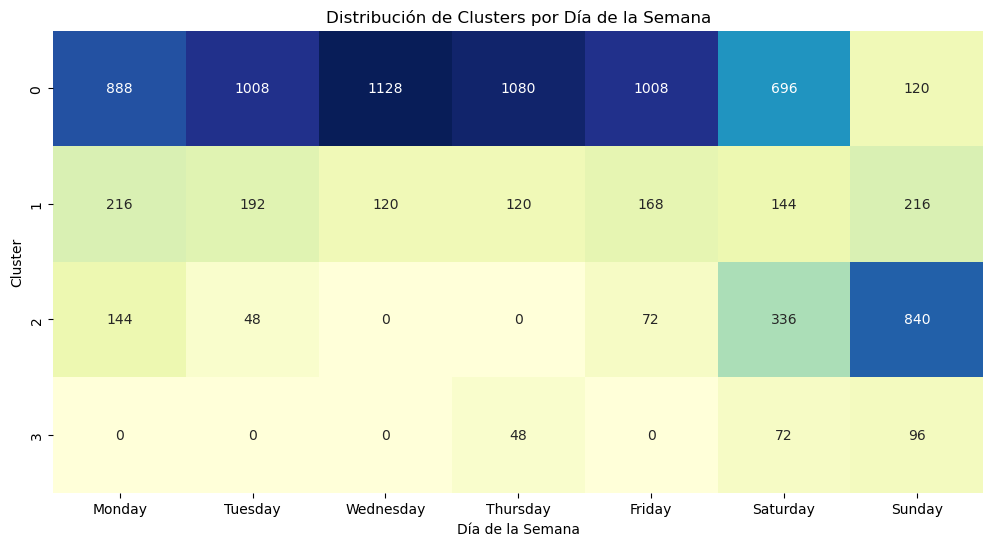

In [127]:
# Definir el orden correcto de los días de la semana
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dtype = pd.CategoricalDtype(categories=weekday_order, ordered=True)

# Convertir la columna 'Weekday' en una categoría ordenada
df_clusters['Weekday'] = df_clusters['Weekday'].astype(weekday_dtype)
df_clusters=df_clusters.sort_values(by="Weekday")
# Agrupar por cluster y día de la semana
weekday_distribution = df_clusters.groupby(['Cluster', 'Weekday']).size().unstack(fill_value=0)

import seaborn as sns

# Mostrar la distribución por día de la semana
plt.figure(figsize=(12, 6))
sns.heatmap(weekday_distribution, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Distribución de Clusters por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cluster')
plt.show()


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_6124\779128631.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_distribution = df_clusters.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)


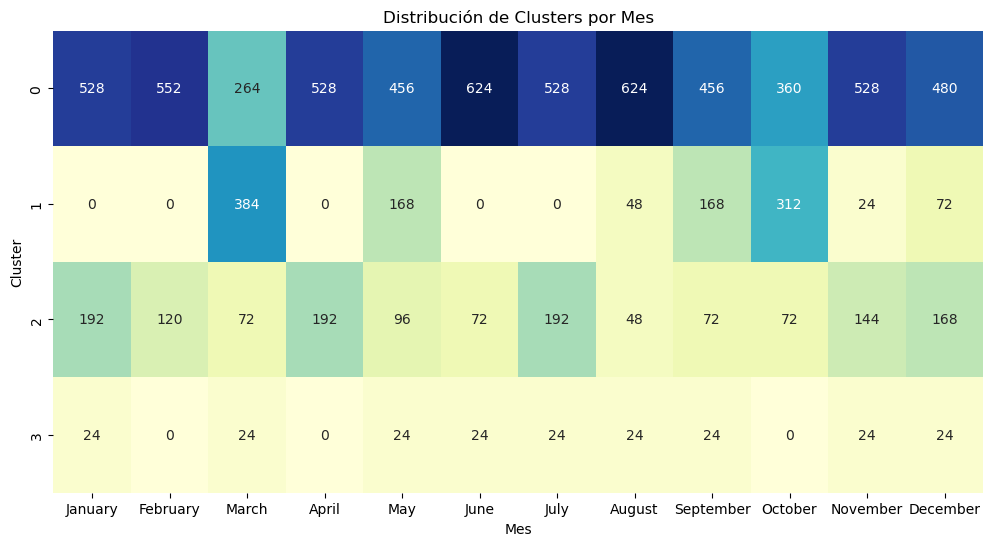

In [128]:
# Definir el orden correcto de los meses del año
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_dtype = pd.CategoricalDtype(categories=month_order, ordered=True)

# Convertir la columna 'Month' en una categoría ordenada
df_clusters['Month'] = df_clusters['Month'].astype(month_dtype)
df_clusters=df_clusters.sort_values(by="Month")

# Agrupar por cluster y mes
month_distribution = df_clusters.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)

# Mostrar la distribución por mes
plt.figure(figsize=(12, 6))
sns.heatmap(month_distribution, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Distribución de Clusters por Mes')
plt.xlabel('Mes')
plt.ylabel('Cluster')
plt.show()


## Forecasting

In [84]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [85]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [86]:
def add_lags(df):
    target_map = df['kwh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    return df

In [87]:
def smape(y_true, y_pred):
  numerator = np.abs(y_true - y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  ratio = numerator / denominator
  return ratio.mean()

In [134]:
train = building_11a.loc[building_11a.index < '2023-12-24']
test = building_11a.loc[building_11a.index >= '2023-12-24']

In [135]:
train =create_features(train)
train =add_lags(train)
test =create_features(test)
test =add_lags(test)

In [199]:
def entrenamiento_modelo(cluster,data,data_cluster):
    # Filtrar las series del cluster actual
    data_cluster=data_cluster.sort_index()
    data=data.sort_index()
    cluster_dates = data_cluster[data_cluster['Cluster'] == cluster]['Date']

    cluster_data_train = data[data.index.isin(cluster_dates)]
    cluster_data_train=cluster_data_train.sort_index()
    # Separar las características (X) y el target (y)
    X_train_cluster = cluster_data_train.drop(columns=['kwh'])
    y_train_cluster = cluster_data_train['kwh']
    
    # Inicializar y entrenar el modelo XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train_cluster, y_train_cluster)
    # Evaluación en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train_cluster)
    cluster_data_train['predictions'] = y_train_pred
    cluster_data_train=cluster_data_train.reset_index()
    predict_df=cluster_data_train.loc[:,["timestamp","kwh","predictions"]]
    return model,predict_df

In [210]:
def inference_models(cluster,data,data_cluster,models):
    data_cluster=data_cluster.sort_index()
    data=data.sort_index()
    cluster_dates = data_cluster[data_cluster['Cluster'] == cluster]['Date']
    cluster_data_infer = data[data.index.isin(cluster_dates)]
    cluster_data_infer=cluster_data_infer.sort_index()
    model=models[f"{cluster}"]
    if not cluster_data_infer.empty:
        X_infer = cluster_data_infer.drop(columns=['kwh'])
        y_test_pred = model.predict(X_infer)
        cluster_data_infer['predictions'] = y_test_pred
        cluster_data_infer=cluster_data_infer.reset_index()
        predict_df=cluster_data_infer.loc[:,["timestamp","kwh","predictions"]]
    else:
        print(f"No hay datos en el testeo para el Cluster {cluster}")
        predict_df=pd.DataFrame()
    return predict_df

In [219]:
models = {}
train_results =pd.DataFrame()
test_results = pd.DataFrame()
for cluster in df_clusters['Cluster'].unique():
    print(f"\nEntrenando modelo para el Cluster {cluster}...")
    modelo,prediction_train=entrenamiento_modelo(cluster,train,df_clusters)
    models[f"{cluster}"]=modelo
    train_results=pd.concat([train_results, prediction_train], ignore_index=True)
    inference=inference_models(cluster,test,df_clusters,models)
    test_results=pd.concat([test_results, inference], ignore_index=True)
train_results=train_results.sort_values(by="timestamp")
test_results=test_results.sort_values(by="timestamp")


Entrenando modelo para el Cluster 2...

Entrenando modelo para el Cluster 0...

Entrenando modelo para el Cluster 3...
No hay datos en el testeo para el Cluster 3

Entrenando modelo para el Cluster 1...
No hay datos en el testeo para el Cluster 1


In [224]:
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))

smape_score=smape(test_results["kwh"], test_results["predictions"])
# Mostrar resultados finales
print("\nResultados :")
print("mae:", mse)
print("smape:", smape_score)


Resultados :
mae: 102.91384648954488
smape: 0.3628449753206868


In [1]:
test_results.head()

NameError: name 'test_results' is not defined

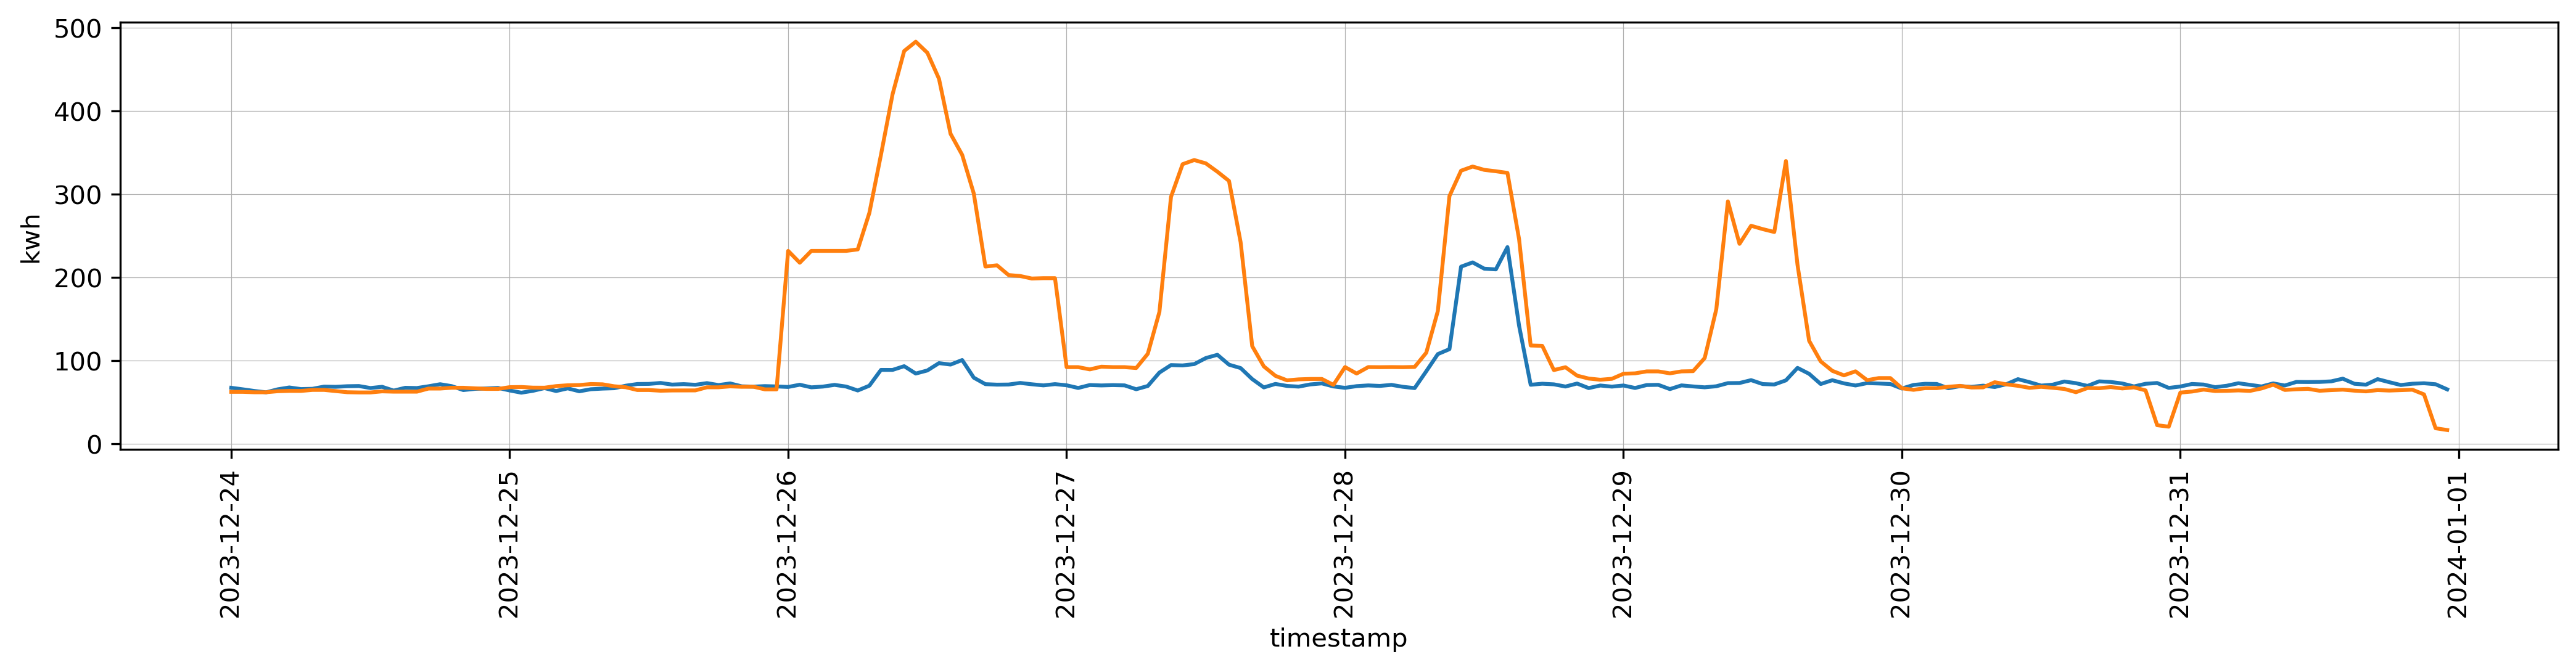

In [223]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh')
sns.lineplot(data=test_results, x='timestamp', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)